# Forecasting Renewable Energy Output Using Long-Short Term Memory and Convolutional Neural Networks

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages required for building CNN + LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Dense, Flatten, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils.vis_utils import plot_model
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

X_solar_train = train[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = train[['v1', 'v2', 'v_50m', 'z0']]
y_wind_train = train['DE_wind_generation_actual']
X_wind_valid = valid[['v1', 'v2', 'v_50m', 'z0']]
y_wind_valid = valid['DE_wind_generation_actual']
X_wind_test = test[['v1', 'v2', 'v_50m', 'z0']]
y_wind_test = test['DE_wind_generation_actual']

## Building a CNN + LSTM TensorFlow Model using Conv1D and LSTM for prediction

In [3]:
#Input layer describing the dimension in which the data will be passed
digit_a = Input(shape=(4,))
#Reshape helps in converting row * col wise data into only col wise data for Conv layer to process
x = Reshape((-1,1))(digit_a)
#Building Conv layers of 128 filters and 2 kernel_size with BatchNormalization
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
#Flattening the output into timedistributed fashion for LSTM to process
out_a = TimeDistributed(Flatten())(x)

#LSTM layer with 1024 units and with no return_sequences
out = LSTM(1024, input_shape = train.shape, return_sequences=False)(out_a)
#Dense layer of 1024 that captures the output of LSTM layer
out = Dense(1024)(out)
#BatchNormalization followed by Dense of 1 layer to get the output of the model
out = BatchNormalization()(out)
out = Dense(1)(out)
#Create the layer and print the summary
model = Model(digit_a, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 1)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 128)            384       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 128)            512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128)            512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            32896 

## Compiling the model by passing adam optimizer, loss=MAE and fetching accuracy metrics 

In [4]:
model.compile('adam', 'mean_absolute_error', ['accuracy'])
history = model.fit(X_solar_train, y_solar_train, validation_data=(X_solar_valid, y_solar_valid), epochs=2)

Epoch 1/2
191/191 [==============================] - 23s 83ms/step - loss: 4708.0927 - accuracy: 0.3703 - val_loss: 3115.7920 - val_accuracy: 0.0421
Epoch 2/2
191/191 [==============================] - 12s 63ms/step - loss: 4548.8805 - accuracy: 0.3853 - val_loss: 3148.4275 - val_accuracy: 0.4682


In [5]:
model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 1s 12ms/step - loss: 1353.0870 - accuracy: 0.5907


[1353.0870361328125, 0.5906656384468079]

### Plotting the keras model

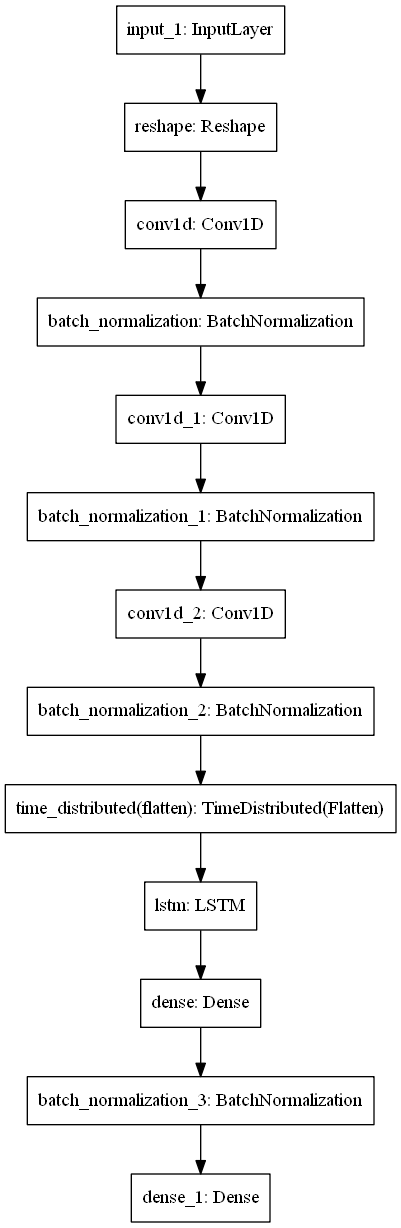

In [6]:
plot_model(
    model, to_file='figs/3-model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Plotting Model's Accuracy and Loss Metrics over Train and Validation sets for Solar

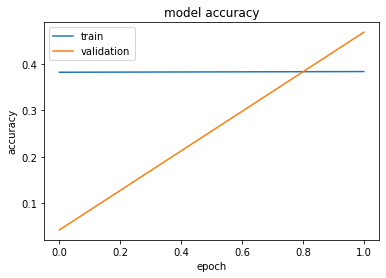

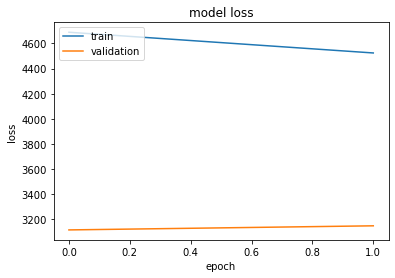

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Plotting Actual vs Predictions on the same plot

In [8]:
trainpred = model.predict(X_solar_train)
valpred = model.predict(X_solar_valid)
testpred = model.predict(X_solar_test)

Text(0.5, 1.0, 'Predicted vs. Actual Solar Generation')

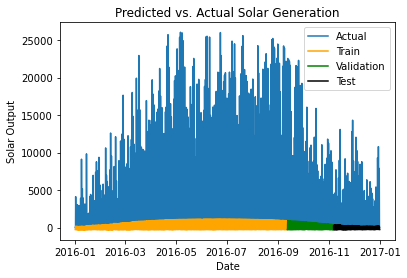

In [9]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = trainpred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = valpred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = testpred

# # Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
trainpredx, =plt.plot(train_df, color='orange', label = 'Train')
valpredx, =plt.plot(valid_df, color='green', label = 'Validation')
testpredx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")

# plt.savefig('figs/3-solar.png', dpi=200)

In [10]:
metrics('cnn+lstm', test[['DE_solar_generation_actual']], testpred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
cnn+lstm,1353.087143,2585.747385,50.850245,3.928885,-0.205416


## Fitting the same model for Wind Dataset

In [11]:
model.compile('adam', 'mean_absolute_error', ['accuracy'])
history = model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=2)

Epoch 1/2
191/191 [==============================] - 21s 72ms/step - loss: 8095.9317 - accuracy: 0.0000e+00 - val_loss: 5574.6943 - val_accuracy: 0.0000e+00
Epoch 2/2
191/191 [==============================] - 12s 63ms/step - loss: 7679.9069 - accuracy: 0.0000e+00 - val_loss: 5051.3335 - val_accuracy: 0.0000e+00


In [12]:
model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 1s 12ms/step - loss: 9185.6602 - accuracy: 0.0000e+00


[9185.66015625, 0.0]

## Model's Accuracy and Loss for Wind Dataset

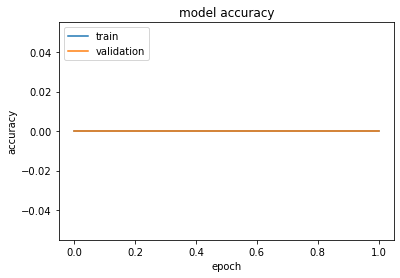

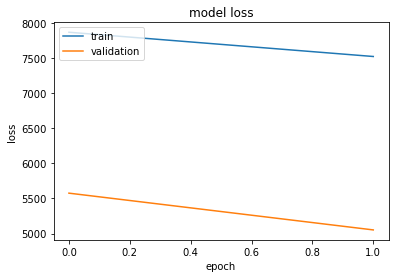

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [14]:
trainpred = model.predict(X_wind_train)
valpred = model.predict(X_wind_valid)
testpred = model.predict(X_wind_test)

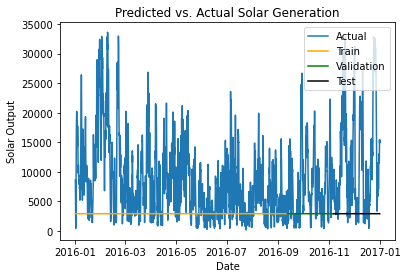

In [15]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = trainpred

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = valpred

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = testpred

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
trainpredx, =plt.plot(train_df, color='orange', label = 'Train')
valpredx, =plt.plot(valid_df, color='green', label = 'Validation')
testpredx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

In [16]:
metrics('cnn+lstm', test[['DE_wind_generation_actual']], testpred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
cnn+lstm,9185.660363,12494.272226,111.777781,4.716513,-1.088985


## The Reason for this is because Wind Energy Production is highly random in nature.
### So CNN + LSTM model couldn't map it as accurately as in Solar Energy Production scenario. So in order to resolve it we use another method - WD that decomposes this variability for our LSTM to predict well